# Analysis of PJ sites CO2 flux

_Gregory Maurer, UNM, April 2015_

First set up environment and load 2009-2014 gapfilled Ameriflux data. There are a couple problems with the data that need to be corrected before the analysis:

* PJ girdle fluxes are a little wonky in 2009. In old Ameriflux files there was much higher uptake (mine do not show this), so I am substituting that data into this analysis because that is the data that has been shown in the past.
    - UPDATE: There were irga problems in 2009 that led to a correction to the raw flux data (takes place in UNM_flux_031010.m). This correction had not been applied to the data I reprocessed, so data prior to Sept 1 2009, had no correction for the bad irga. This has now been fixed and the data are reprocessed, so the substitution of old Ameriflux data for 2009 is no longer necessary.
* Early 2009 Fc is gapfilled at PJ girdle, so I am setting the start of our time period at the end of this gapfilling.

In [1]:
import sys
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )
#sys.path.append( '..\\NMEG_utils\\py_modules\\' )

%matplotlib inline
import load_nmeg as ld
import transform_nmeg as tr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# WARNING - ameriflux files have changed - this will need to be updated or directed to the archive
af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'
#af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'

start = 2009
end = 2014

pjc = ld.get_multiyr_aflx( 'US-Mpj', af_path, gapfilled=True, startyear=start, endyear=end)
pjg = ld.get_multiyr_aflx( 'US-Mpg', af_path, gapfilled=True, startyear=start, endyear=end)
jsav = ld.get_multiyr_aflx( 'US-Wjs', af_path, gapfilled=True, startyear=start, endyear=end)

Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2013_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2014_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2013_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_

## Substitute old AF data in for PJG 2009

In [2]:
# No longer needed

# Substituting old 2009 C flux data in at PJG because there is a big difference that year
# between my files and others. I'm suspicious of this move, but it makes sense for now
# old_path = '/home/greg/sftp/eddyflux/Ameriflux_files/'
# old_pjg_2009 = ld.load_aflx_file( old_path + 'US-Mpg_2009_gapfilled.txt' , 2009 )
# pjg.FC[ pjg.index.year == 2009 ] = old_pjg_2009.FC
# pjg.GPP[ pjg.index.year == 2009 ] = old_pjg_2009.GPP
# pjg.RE[ pjg.index.year == 2009 ] = old_pjg_2009.RE


## Remove early 2009 gapfilled periods

In [2]:
# For all 3 dataframes, remove the periods when PJG was gapfilled
# Gapfilling at PJG ends on Feb 23 2009
end_gapfill = dt.datetime( 2009, 2, 23, 15, 0, 0 )
print(pjg.shape)
for df in [ pjc, pjg, jsav ]:
    rows2drop = df.index[ df.index < end_gapfill ]
    df.drop( rows2drop, inplace=True )
    
print(pjg.shape)

(105168, 31)
(102595, 31)


In [25]:
# Calculate percentage of precip values filled with PRISM
# between 2009 and 2013 - this is in Laura's paper
pjc_nrow = pjc.loc[pjc.index.year < 2013,].shape[0]
pjg_nrow = pjg.loc[pjg.index.year < 2013,].shape[0]
pjc_filled = pjc.loc[pjc.index.year < 2013,].P_F_FLAG.sum()
pjg_filled = pjg.loc[pjg.index.year < 2013,].P_F_FLAG.sum()

print( 'pjc ' + str(pjc_filled/pjc_nrow))
print( 'pjg ' + str(pjg_filled/pjg_nrow))

pjc 0.000458892145542825
pjg 0.1100897060129674


## Correction for greater NEE at PJG pre-girdling

In [4]:
def get_slope_int( var, pjg, pjc ):
    girdle_event = dt.datetime( 2009, 9, 5, 12, 0, 0 )
    y = pjg[var][ pjg.index < girdle_event ]
    x = pjc[var][ pjc.index < girdle_event ]
    # Remove NaNs
    idx = ( ~np.isnan( x + y ))
    x = x[ idx ]
    y = y[ idx ]
    # Get a slope and intercept of the relation between PJG and PJC
    A = np.vstack( [ x, np.ones( len( x ) ) ] ).T
    slope, icpt =  np.linalg.lstsq( A, y )[0]
    return slope, icpt
# Correct NEE
slope, icpt = get_slope_int( 'FC_F', pjg, pjc )
print('NEE Slope: ' + str( slope ) + '  Intercept: ' + str( icpt ))
# Now correct PJC to PJG
pjc_FC_cor = (pjc.FC_F * slope) + icpt
pjc[ 'FC_F_cor' ] = pjc_FC_cor
# Correct GPP
slope, icpt = get_slope_int( 'GPP', pjg, pjc )
print('GPP Slope: ' + str( slope ) + '  Intercept: ' + str( icpt ))
# Now correct PJC to PJG
pjc_GPP_cor = (pjc.GPP * slope) + icpt
pjc[ 'GPP_cor' ] = pjc_GPP_cor
# Correct Reco
slope, icpt = get_slope_int( 'RECO', pjg, pjc )
print('RECO Slope: ' + str( slope ) + '  Intercept: ' + str( icpt ))
# Now correct PJC to PJG
pjc_RECO_cor = (pjc.RECO * slope) + icpt
pjc[ 'RECO_cor' ] = pjc_RECO_cor

NEE Slope: 1.01454884383  Intercept: -0.186170616369
GPP Slope: 0.968824968218  Intercept: 0.126211573912
RECO Slope: 0.89089077148  Intercept: 0.00833316080781


## Calculate ET and create daily data for each site

In [16]:
pjg_d = tr.resample_30min_aflx( pjg )
pjc_d = tr.resample_30min_aflx( pjc, c_fluxes=[ 'GPP', 'GPP_cor', 'RECO', 'RECO_cor', 'FC_F', 'FC_F_cor' ] )
jsav_d = tr.resample_30min_aflx( jsav )

pjc_d.YEAR = pjc_d.index.year;
pjg_d.YEAR = pjg_d.index.year;
jsav_d.YEAR = jsav_d.index.year;

## Calculate total Precip and ET per year

In [22]:
#
df_ET_P = pd.DataFrame( index = np.asarray(range(start, end+1)))

#new = ld.add_WY_cols(d.Mpg)
#mpg = pd.concat([d.Mpg, new.year_w], axis=1)
gby = pjg_d.ET_mm_int_0.groupby(pjg_d.index.year)
df_ET_P['Girdle ET'] = gby.sum()
gby = pjc_d.ET_mm_int_0.groupby(pjc_d.index.year)
df_ET_P['Control ET'] = gby.sum()
gby = pjg_d.P_F.groupby(pjg_d.index.year)
df_ET_P['Girdle Precip'] = gby.sum()
gby = pjc_d.P_F.groupby(pjc_d.index.year)
df_ET_P['Control Precip'] = gby.sum()

df_ET_P

,Girdle ET,Control ET,Girdle Precip,Control Precip
2009,366.754755,318.538314,322.93017,329.45052
2010,392.736322,408.280116,347.98000,328.92627
2011,256.508241,279.035578,255.77800,273.80000
2012,264.206906,301.481257,157.24000,180.30000
2013,349.520734,334.791955,337.89400,340.50000
2014,450.436134,489.027531,391.16000,383.06400


## Plot timeseries

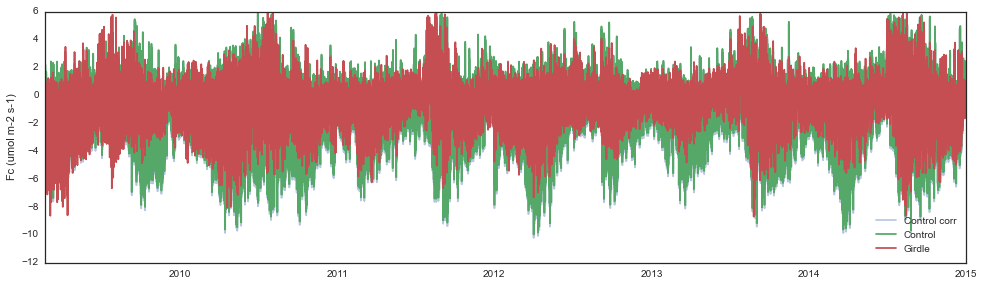

In [6]:
sns.set_style( 'white' )

fig0 = plt.figure( figsize=( 16.5, 4.5 ), dpi=100, facecolor='w', edgecolor='k' )
ax1 = fig0.add_subplot( 111 )
h1 = ax1.plot( pjc.index, pjc.FC_F_cor, alpha=.4 ) 
h2 = ax1.plot( pjc.index, pjc.FC_F )
h3 = ax1.plot( pjg.index, pjg.FC_F )
plt.ylabel('Fc (umol m-2 s-1)')
plt.legend( [ 'Control corr','Control', 'Girdle'], loc='lower right' )

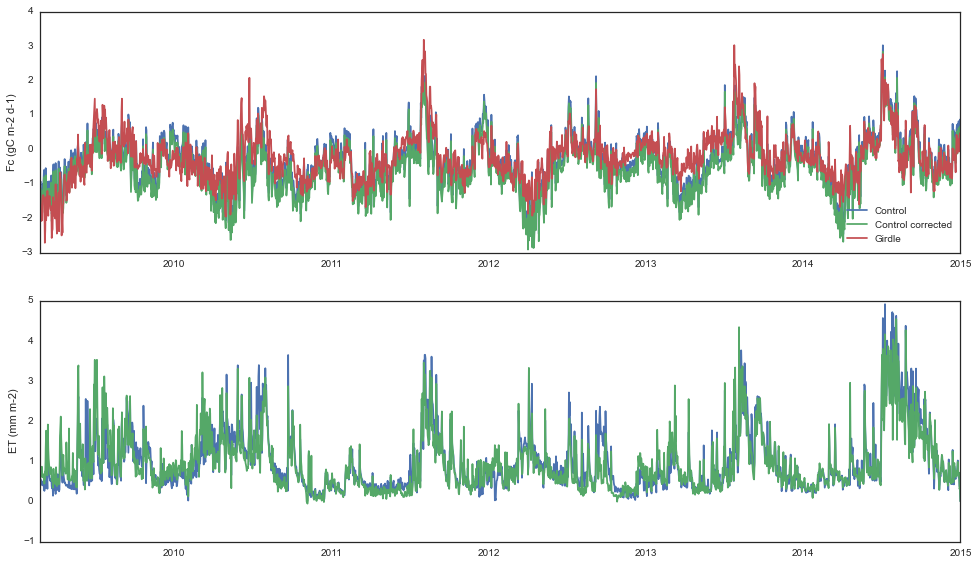

In [7]:
fig1 = plt.figure( figsize=( 16.5, 9.5 ), dpi=100, facecolor='w', edgecolor='k' )
ax1 = fig1.add_subplot(211)
h1 = ax1.plot( pjc_d.index, pjc_d.FC_F_g_int )
h2 = ax1.plot( pjc_d.index, pjc_d.FC_F_cor_g_int )
h3 = ax1.plot( pjg_d.index, pjg_d.FC_F_g_int )

plt.ylabel('Fc (gC m-2 d-1)')
plt.legend( ['Control', 'Control corrected', 'Girdle', ], loc='lower right' )
ax2 = fig1.add_subplot(212)
h1 = ax2.plot( pjc_d.index, pjc_d.ET_mm_int_0 ) 
h2 = ax2.plot( pjg_d.index, pjg_d.ET_mm_int_0 )
plt.ylabel('ET (mm m-2)')
plt.show()
#plt.legend( ['Control', 'Girdle'], loc='lower right' )

## Compare girdle and control

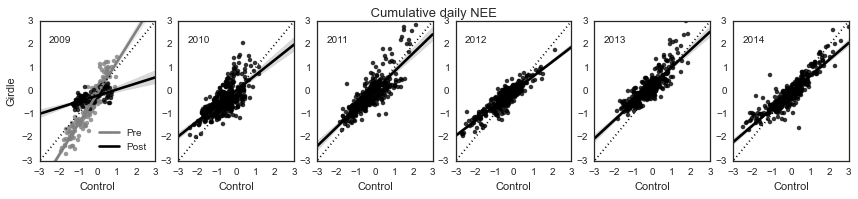

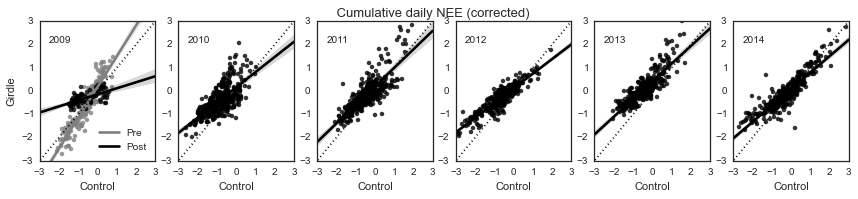

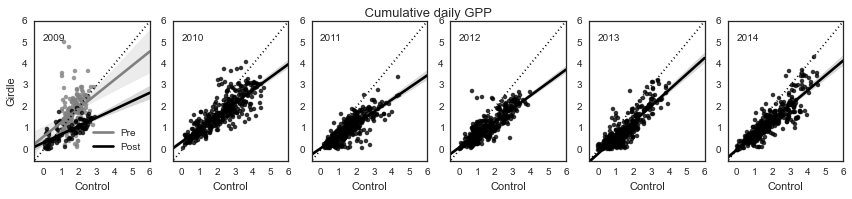

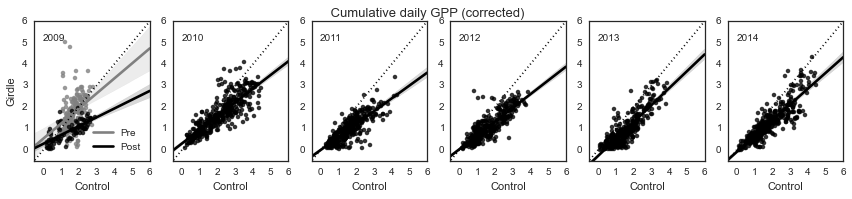

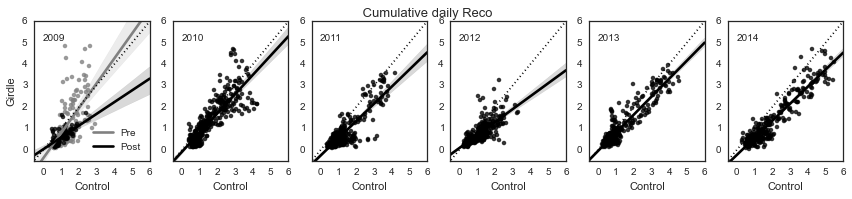

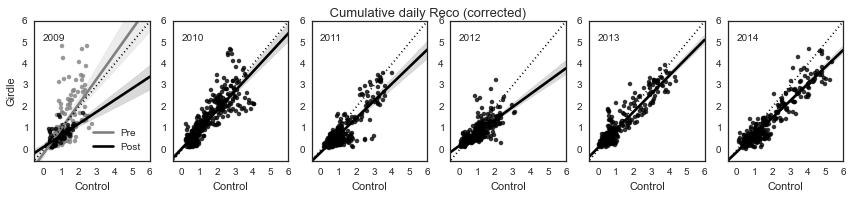

In [14]:
def plot_xy_year( start_yr, end_yr, var, fig, corrected=False, lims=[-3,3] ):
    numyrs = end_yr - start_yr + 1;
    gvar = var + '_g_int'
    if corrected:
        cvar = var + '_cor_g_int'
    else:
        cvar = var + '_g_int'
    
    for i, yr in enumerate( range( start_yr, end_yr + 1 ) ):
        ax = fig.add_subplot( 1, numyrs, i+1 )
        plt.ylim(lims)
        plt.xlim(lims)
        # in 2009 separate by pre/post girdling
        if yr==2009:
            pjc_sub = pjc_d[ np.logical_and(pjc_d.index.year == yr, pjc_d.index.month < 9) ]
            pjg_sub = pjg_d[ np.logical_and(pjg_d.index.year == yr, pjg_d.index.month < 9) ]
            pjc_sub_post = pjc_d[ np.logical_and(pjc_d.index.year == yr, pjc_d.index.month > 9) ]
            pjg_sub_post = pjg_d[ np.logical_and(pjg_d.index.year == yr, pjg_d.index.month > 9) ]
            sns.regplot( pjc_sub[ cvar ], pjg_sub[ gvar ],  marker='o', color='gray' )
            sns.regplot( pjc_sub_post[ cvar ], pjg_sub_post[ gvar ],  marker='o', color='black' )
            plt.legend(['Pre', 'Post'], loc='lower right')
        else:
            pjc_sub = pjc_d[ pjc_d.index.year == yr ]
            pjg_sub = pjg_d[ pjg_d.index.year == yr ]
            sns.regplot( pjc_sub[ cvar ], pjg_sub[ gvar ], marker='o', color='black' )
        #jsav_sub = jsav_d[ jsav_d.index.year == yr ]
        #ax.scatter( pjg_sub[ var ] , pjc_sub[ var ], marker='o' )
        ax.plot( ( -15, 15 ),( -15, 15 ), ls=':', color='black' )
        plt.text( lims[0]+0.5, lims[1]-0.9, str( yr ))
        plt.xlabel( 'Control')
        if i==0:
            plt.ylabel( 'Girdle')
        else:
            plt.ylabel('')

figX = plt.figure( figsize=( 14.5, 2.5 ), dpi=100, facecolor='w', edgecolor='k' )
plot_xy_year( 2009, 2014, 'FC_F', figX )
plt.suptitle(' Cumulative daily NEE', size=13 )

figXcor = plt.figure( figsize=( 14.5, 2.5 ), dpi=100, facecolor='w', edgecolor='k' )
plot_xy_year( 2009, 2014, 'FC_F', figXcor, corrected=True )
plt.suptitle(' Cumulative daily NEE (corrected)', size=13 )

figY = plt.figure( figsize=( 14.5, 2.5 ), dpi=100, facecolor='w', edgecolor='k' )
plot_xy_year( 2009, 2014, 'GPP', figY, lims=[-.50, 6] )
plt.suptitle(' Cumulative daily GPP', size=13 )

figYcor = plt.figure( figsize=( 14.5, 2.5 ), dpi=100, facecolor='w', edgecolor='k' )
plot_xy_year( 2009, 2014, 'GPP', figYcor, corrected=True, lims=[-.50, 6] )
plt.suptitle(' Cumulative daily GPP (corrected)', size=13 )

figZ = plt.figure( figsize=( 14.5, 2.5 ), dpi=100, facecolor='w', edgecolor='k' )
plot_xy_year( 2009, 2014, 'RECO', figZ, lims=[-.5, 6])
plt.suptitle(' Cumulative daily Reco', size=13 )

figZcor = plt.figure( figsize=( 14.5, 2.5 ), dpi=100, facecolor='w', edgecolor='k' )
plot_xy_year( 2009, 2014, 'RECO', figZcor, corrected=True, lims=[-.5, 6])
plt.suptitle(' Cumulative daily Reco (corrected)', size=13 )


## Plot cumulative NEE

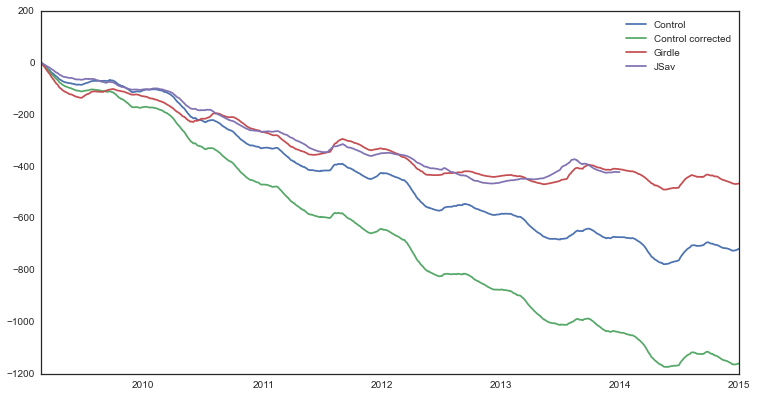

In [9]:
fig3 = plt.figure( figsize=( 12.5, 6.5 ), dpi=100, facecolor='w', edgecolor='k' )
var = 'FC_F_g_int'
plt.plot( pjc_d.index, pjc_d[ var ].cumsum())
plt.plot( pjc_d.index, pjc_d[ 'FC_F_cor_g_int' ].cumsum())
plt.plot( pjg_d.index, pjg_d[ var ].cumsum())
jsav_sub = jsav_d[ jsav_d.index.year < 2014 ]
plt.plot( jsav_sub.index, jsav_sub[ var ].cumsum())
plt.legend( ['Control', 'Control corrected', 'Girdle', 'JSav'], loc='upper right' )


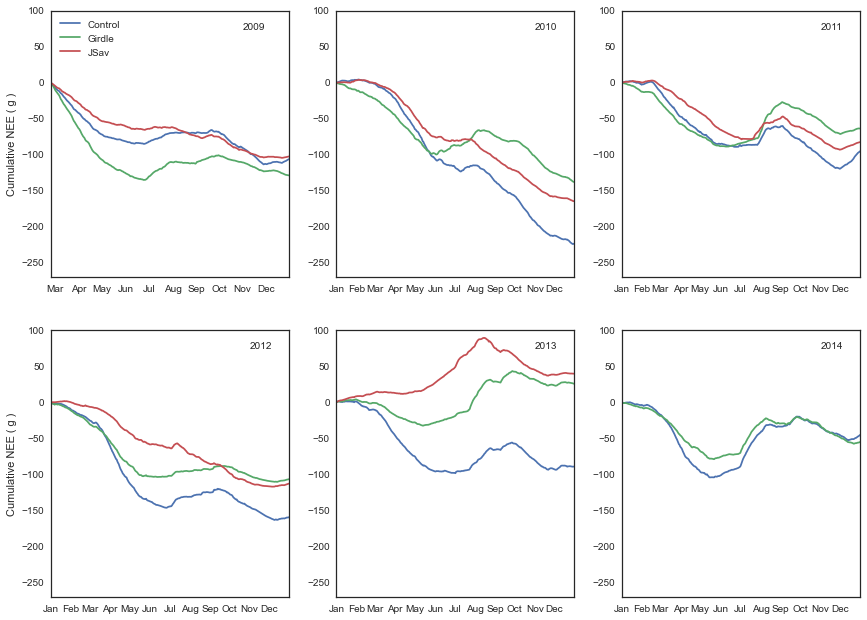

In [10]:
def plot_cumsum_year( yr, ax, var, annoty=75 ):
    
    pjc_sub = pjc_d[ pjc_d.index.year == yr ]
    pjg_sub = pjg_d[ pjg_d.index.year == yr ]
    jsav_sub = jsav_d[ jsav_d.index.year == yr ]
    
    ax.plot( pjc_sub.index, pjc_sub[ var ].cumsum())
    ax.plot( pjg_sub.index, pjg_sub[ var ].cumsum())
    if yr < 2014 :
        ax.plot( jsav_sub.index, jsav_sub[ var ].cumsum())
    plt.text( dt.datetime( yr, 11, 1 ), annoty, str( yr ))
    # Set major x ticks on Mondays.
    ax.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter( '%b' ))
    

fig3p5 = plt.figure( figsize=( 14.5, 10.5 ), dpi=100, facecolor='w', edgecolor='k' )
for i, figyr in enumerate( range( start, end + 1 ) ):
    ax1 = fig3p5.add_subplot( 2, 3, i + 1 )
    plot_cumsum_year( figyr, ax1, 'FC_F_g_int' )
    plt.ylim([ -270, 100])
    if i==0:
        plt.legend( ['Control', 'Girdle', 'JSav'], loc='upper left' )
        plt.ylabel( 'Cumulative NEE ( g )')
    elif i==3:
        plt.ylabel( 'Cumulative NEE ( g )')
            
    

## Plot cumulative GPP

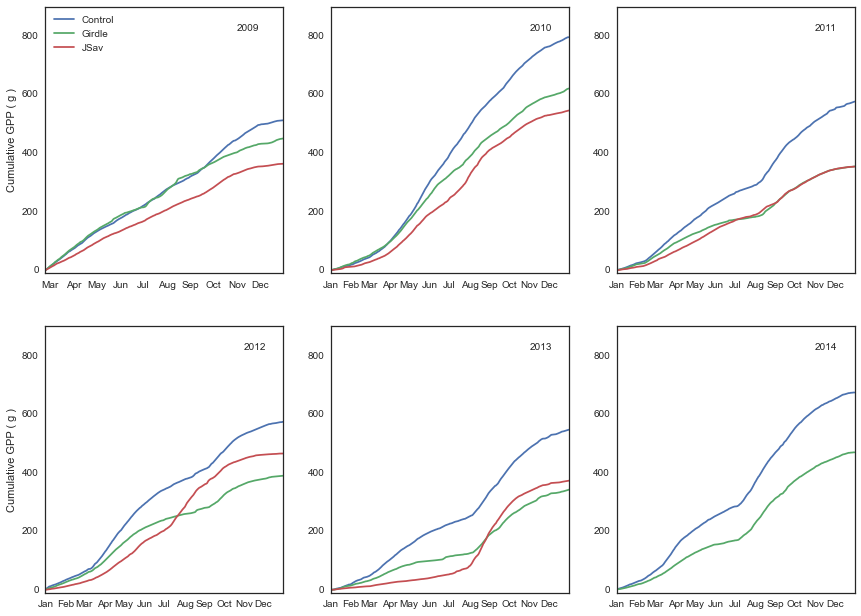

In [11]:
fig4 = plt.figure( figsize=( 14.5, 10.5 ), dpi=100, facecolor='w', edgecolor='k' )
for i, figyr in enumerate( range( start, end + 1 ) ):
    ax1 = fig4.add_subplot( 2, 3, i + 1 )
    plot_cumsum_year( figyr, ax1, 'GPP_g_int', annoty=820 )
    plt.ylim([ -10, 900])
    if i==0:
        plt.legend( ['Control', 'Girdle', 'JSav'], loc='upper left' )
        plt.ylabel( 'Cumulative GPP ( g )')
    elif i==3:
        plt.ylabel( 'Cumulative GPP ( g )')

## Plot cumulative RE

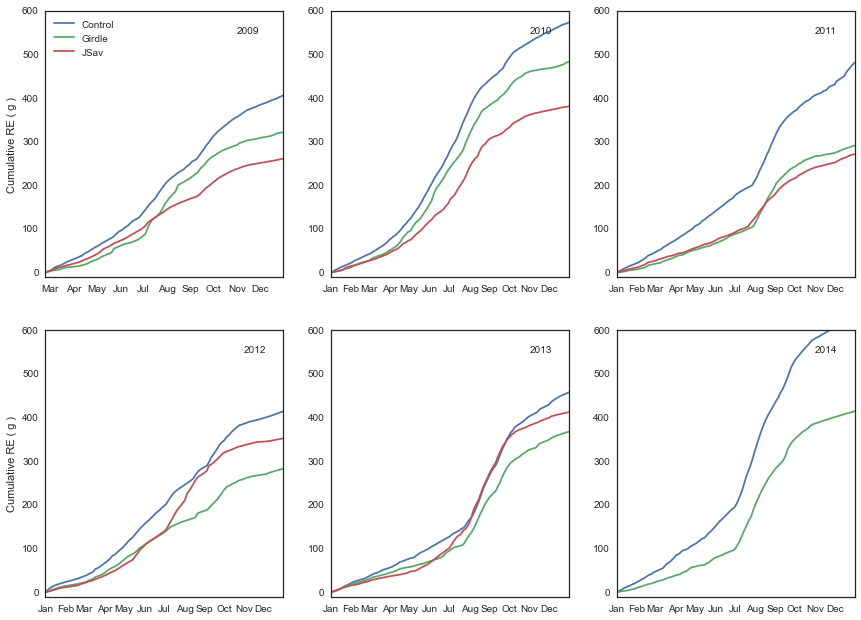

In [12]:
fig5 = plt.figure( figsize=( 14.5, 10.5 ), dpi=100, facecolor='w', edgecolor='k' )
for i, figyr in enumerate( range( start, end + 1 ) ):
    ax1 = fig5.add_subplot( 2, 3, i + 1 )
    plot_cumsum_year( figyr, ax1, 'RECO_g_int', annoty=550 )
    plt.ylim([ -10, 600])
    if i==0:
        plt.legend( ['Control', 'Girdle', 'JSav'], loc='upper left' )
        plt.ylabel( 'Cumulative RE ( g )')
    elif i==3:
        plt.ylabel( 'Cumulative RE ( g )')

## Monthly NEE, GPP, RE differences between control and girdle

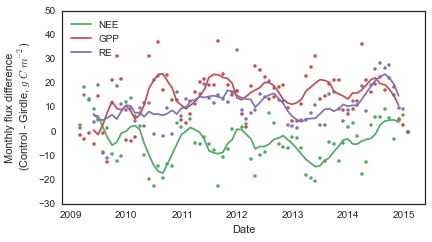

In [13]:
# First make monthly datasets
pjg_m = tr.resample_30min_aflx( pjg, freq='1M' )
pjc_m = tr.resample_30min_aflx( pjc, freq='1M', c_fluxes=[ 'GPP', 'GPP_cor', 'RECO', 'RECO_cor', 'FC_F', 'FC_F_cor' ] )
jsav_m = tr.resample_30min_aflx( jsav, freq='1M' )

Fc_diff = pjc_m.FC_F_g_int - pjg_m.FC_F_g_int
GPP_diff = pjc_m.GPP_g_int - pjg_m.GPP_g_int
RE_diff = pjc_m.RECO_g_int - pjg_m.RECO_g_int

fig6 = plt.figure( figsize=( 6.5, 3.45 ), dpi=300, facecolor='w', edgecolor='k' )
colors = sns.color_palette()
plt.scatter( pjc_m.index, Fc_diff, marker='o', color=colors[1], s=10 )
plt.scatter( pjc_m.index, GPP_diff, marker='o', color=colors[2], s=10  )
plt.scatter( pjc_m.index, RE_diff, marker='o', color=colors[3], s=10  )
plt.plot( pjc_m.index, pd.rolling_mean( Fc_diff, window=6, center=True ), color=colors[1] )
plt.plot( pjc_m.index, pd.rolling_mean( GPP_diff, window=6, center=True ), color=colors[2] )
plt.plot( pjc_m.index, pd.rolling_mean( RE_diff, window=6, center=True ), color=colors[3] )
plt.xlabel( 'Date' )
plt.ylabel( 'Monthly flux difference \n (Control - Girdle, $g\ C\ m^{-2}$)' )
plt.legend( ['NEE', 'GPP', 'RE'], loc='upper left' )
plt.savefig('pj_monthly_diff_fig.tiff', dpi=150)